<a href="https://colab.research.google.com/github/alx87grd/DimensionlessPolicies/blob/main/pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimentionless policies for inverted pendulums

In [ ]:
!git clone https://github.com/SherbyRobotics/pyro
import sys
sys.path.append('/content/pyro')

from IPython import display

fatal: destination path 'pyro' already exists and is not an empty directory.


### Resolution selection

In [ ]:
# res = 'test'
res = 'std'
# res = 'plus'
#res = 'hi'

# Source Code

In [ ]:
##############################################################################
import numpy as np
import matplotlib.pyplot as plt
##############################################################################
from pyro.dynamic  import pendulum
from pyro.planning import discretizer
from pyro.analysis import costfunction
from pyro.planning import dynamicprogramming
from pyro.analysis import graphical
##############################################################################

In [ ]:
def case( m , g , l , t_max_star , q_star , case_name = 'test ', show = True, rax = None , rax2 = None, res = 'reg', legend = 1):

    # Additionnal fixed domain dimentionless parameters
    theta_star  = 2.0 * np.pi
    dtheta_star = 1.0 * np.pi
    time_star   = 2.0 * np.pi * 20.0

    # Combined system parameters
    omega = np.sqrt( ( g / l  ) )
    mgl   = m * g * l

    # Dimentional parameters
    t_max  = t_max_star * mgl
    q      = q_star * mgl
    theta  = theta_star
    dtheta = dtheta_star * omega
    time   = time_star / omega
    J_max  = mgl**2 / omega * time_star * ( ( q_star * theta_star )**2 + t_max_star**2 )

    print('\n\nCase :' + case_name )
    print('----------------------------------------------------')
    print(' m=',m,' g=',g,' l=',l,' t_max=', t_max, ' q=', q)

    ################################
    # Dynamic system definition
    ################################

    sys  = pendulum.InvertedPendulum()

    # kinematic
    sys.lc1 = l

    sys.l1       = sys.lc1
    sys.l_domain = sys.lc1 * 2

    # dynamic
    sys.m1       = m
    sys.I1       = 0
    sys.gravity  = g
    sys.d1       = 0

    sys.u_ub[0]  = + t_max
    sys.u_lb[0]  = - t_max

    sys.x_ub = np.array([ + theta , + dtheta ])
    sys.x_lb = np.array([ - theta , - dtheta ])

    ################################
    # Discritized grid
    ################################

    if res == 'test' :

        dt = 0.5
        nx = 21
        nu = 3

    elif res == 'plus' :

        dt = 0.05
        nx = 301
        nu = 101

    elif res == 'hi' :

        dt = 0.025
        nx = 501
        nu = 101

    else:

        dt = 0.05
        nx = 301
        nu = 21

    grid_sys = discretizer.GridDynamicSystem( sys , [nx,nx] , [nu] , dt , True )

    ################################
    # Cost function
    ################################

    qcf = costfunction.QuadraticCostFunction.from_sys(sys)

    qcf.xbar = np.array([ 0 , 0 ]) # target
    qcf.INF  = J_max

    qcf.Q[0,0] = q ** 2
    qcf.Q[1,1] = 0.0

    qcf.R[0,0] = 1.0

    ################################
    # Computing optimal policy
    ################################

    dp = dynamicprogramming.DynamicProgrammingWithLookUpTable( grid_sys, qcf )

    steps = int( time / dt )

    dp.compute_steps( steps )


    #grid_sys.fontsize = 10
    qcf.INF  = 0.1 * J_max
    dp.clean_infeasible_set()


    ##################################
    # Fig param
    ##################################

    dpi      = 300
    fontsize = 10
    figsize  = (4, 3)

    ##################################
    # Dimensional policy plot
    ##################################

    fig = plt.figure( figsize = figsize, dpi=dpi, frameon=True)
    fig.canvas.manager.set_window_title( 'dimentionless policy' )
    ax  = fig.add_subplot(1, 1, 1)

    xname = r'$\theta  \; [rad]$'
    yname = r'$\dot{\theta} \; [rad/sec]$'
    zname = r'$\tau \; [Nm]$'

    sys.state_label[0] = r'$\theta$'
    sys.state_label[1] = r'$\dot{\theta}$'
    sys.input_label[0] = r'$\tau$'

    xrange = 2.0 * np.pi
    yrange = np.pi * np.sqrt( 10 / 1. )
    zrange = 20.

    ax.set_ylabel( yname, fontsize = fontsize )
    ax.set_xlabel( xname, fontsize = fontsize )

    x_level = grid_sys.x_level[ 0 ]
    y_level = grid_sys.x_level[ 1 ]


    u         = grid_sys.get_input_from_policy( dp.pi , 0 )
    J_grid_nd = grid_sys.get_grid_from_array( u )
    J_grid_2d = grid_sys.get_2D_slice_of_grid( J_grid_nd , 0 , 1 )

    mesh = ax.pcolormesh( x_level,
                          y_level,
                          J_grid_2d.T,
                          shading='gouraud',
                          cmap = 'bwr',
                          vmin = -zrange,
                          vmax = zrange,
                          rasterized = True )

    ax.tick_params( labelsize = fontsize )
    ax.grid(True)
    ax.set_ylim( -yrange, +yrange)
    ax.set_xlim( -xrange, xrange)

    cbar = fig.colorbar( mesh )

    cbar.set_label(zname, fontsize = fontsize , rotation = 90 )

    fig.tight_layout()
    #fig.show()
    fig.savefig( case_name + '_policy.pdf')
    fig.savefig( case_name + '_policy.png')
    fig.savefig( case_name + '_policy.jpg')

    if show:
        plt.show()
    else:
        plt.close( fig )


    ##################################
    # Trajectory plot
    ##################################

    ctl = dp.get_lookup_table_controller()

    # Simulation
    cl_sys = ctl + sys
    cl_sys.x0   = np.array([-3.14, 0.])
    cl_sys.compute_trajectory( 10 , 6001, 'euler')

    tp = graphical.TrajectoryPlotter( sys )
    tp.fontsize = fontsize
    tp.plot( cl_sys.traj , 'xu',  show = False)
    tp.plots[1].set_ylim([-5.5, 5.5])
    tp.plots[2].set_ylim([-zrange, zrange])
    tp.fig.savefig( case_name + '_traj.pdf')
    tp.fig.savefig( case_name + '_traj.png')
    tp.fig.savefig( case_name + '_traj.jpg')

    if show:
        plt.show()
    else:
        plt.close( tp.fig )


    ##################################
    # Dimensionless policy plot
    ##################################

    fig = plt.figure( figsize= figsize, dpi=dpi, frameon=True)
    fig.canvas.manager.set_window_title( 'dimentionless policy' )
    ax  = fig.add_subplot(1, 1, 1)

    xname = r'$\theta^*$'#self.sys.state_label[x] #+ ' ' + self.sys.state_units[x]
    yname = r'$\dot{\theta}^* = \frac{\dot{\theta}}{\omega}$'#self.sys.state_label[y] #+ ' ' + self.sys.state_units[y]
    zname = r'$\tau^*=\frac{\tau}{mgl}$'

    ax.set_ylabel(yname, fontsize = fontsize )
    ax.set_xlabel(xname, fontsize = fontsize )

    x_level = grid_sys.x_level[ 0 ] * 1
    y_level = grid_sys.x_level[ 1 ] * (1 / omega)


    u = grid_sys.get_input_from_policy( dp.pi , 0 )

    u2 =  u * (1/mgl)

    J_grid_nd = grid_sys.get_grid_from_array( u2 )

    J_grid_2d = grid_sys.get_2D_slice_of_grid( J_grid_nd , 0 , 1 )

    mesh = ax.pcolormesh( x_level,
                          y_level,
                          J_grid_2d.T,
                          shading='gouraud',
                          cmap = 'bwr',
                          rasterized = True )

    ax.tick_params( labelsize = fontsize )
    ax.grid(True)

    cbar = fig.colorbar( mesh )

    cbar.set_label(zname, fontsize = fontsize , rotation = 90 )

    fig.tight_layout()
    #fig.show()
    fig.savefig( case_name + '_dimpolicy.pdf')
    fig.savefig( case_name + '_dimpolicy.png')
    fig.savefig( case_name + '_dimpolicy.jpg')

    if show:
        plt.show()
    else:
        plt.close( fig )


    if rax is not None:

    ###############################
    # 2D policy regime figure (dtheta = 0 )
    ###############################

        n = 101
        x_min = - theta_star - 0.1
        x_max = + theta_star + 0.1

        x = np.linspace( x_min, x_max, n)
        u = np.zeros(n)

        for i in range(n):
            ri = 0
            xi = np.array([ x[i] , 0.0 ])
            ti = 0
            u[i] = ctl.c( xi, ri, ti) * (1/mgl)


        if legend == 1:
            rax.plot( x , u , label= r'$\tau_{max}^* =$ %0.1f' % t_max_star )
        elif legend == 2:
            rax.plot( x , u , label= r'$q^* =$ %0.2f' % q_star )
        else:
            rax.plot( x , u )

        rax.set_xlim([ x_min, x_max ])
        rax.set_xlabel( xname, fontsize = fontsize )
        rax.grid(True)
        rax.tick_params( labelsize = fontsize )
        rax.set_ylabel( zname, fontsize = fontsize )

    if rax2 is not None:

    ###############################
    # 2D policy regime figure (theta = -np.pi )
    ###############################

        n = 101
        x_min = - dtheta_star - 0.1
        x_max = + dtheta_star + 0.1

        x = np.linspace( x_min, x_max, n)
        u = np.zeros(n)

        for i in range(n):
            ri = 0
            xi = np.array([ -np.pi , x[i] ])
            ti = 0
            u[i] = ctl.c( xi, ri, ti) * (1/mgl)


        if legend == 1:
            rax2.plot( x , u , label= r'$\tau_{max}^* =$ %0.1f' % t_max_star )
        elif legend == 2:
            rax2.plot( x , u , label= r'$q^* =$ %0.2f' % q_star )
        else:
            rax2.plot( x , u )

        rax2.set_xlim([ x_min, x_max ])
        rax2.set_xlabel( yname, fontsize = fontsize )
        rax2.grid(True)
        rax2.tick_params( labelsize = fontsize )
        rax2.set_ylabel( zname, fontsize = fontsize)


    return dp , cl_sys

# Main Figures

## computation



Case :c1
----------------------------------------------------
 m= 1  g= 10  l= 1  t_max= 5.0  q= 1.0

Generating a mesh for: Inverted Pendulum
---------------------------------------------------
State space dimensions: 2  Input space dimension: 1
Number of nodes: 90601  Number of actions: 21
Number of node-action pairs: 1902621
---------------------------------------------------
Computing nodes..  completed in 0.32 sec
Computing actions..  completed in 0.00 sec
Computing x_next array.. 10000/90601 nodes computed in 15.72 sec
Computing x_next array.. 20000/90601 nodes computed in 25.39 sec
Computing x_next array.. 30000/90601 nodes computed in 34.54 sec
Computing x_next array.. 40000/90601 nodes computed in 42.85 sec
Computing x_next array.. 50000/90601 nodes computed in 52.53 sec
Computing x_next array.. 60000/90601 nodes computed in 61.85 sec
Computing x_next array.. 70000/90601 nodes computed in 69.82 sec
Computing x_next array.. 80000/90601 nodes computed in 79.47 sec
Computing x_

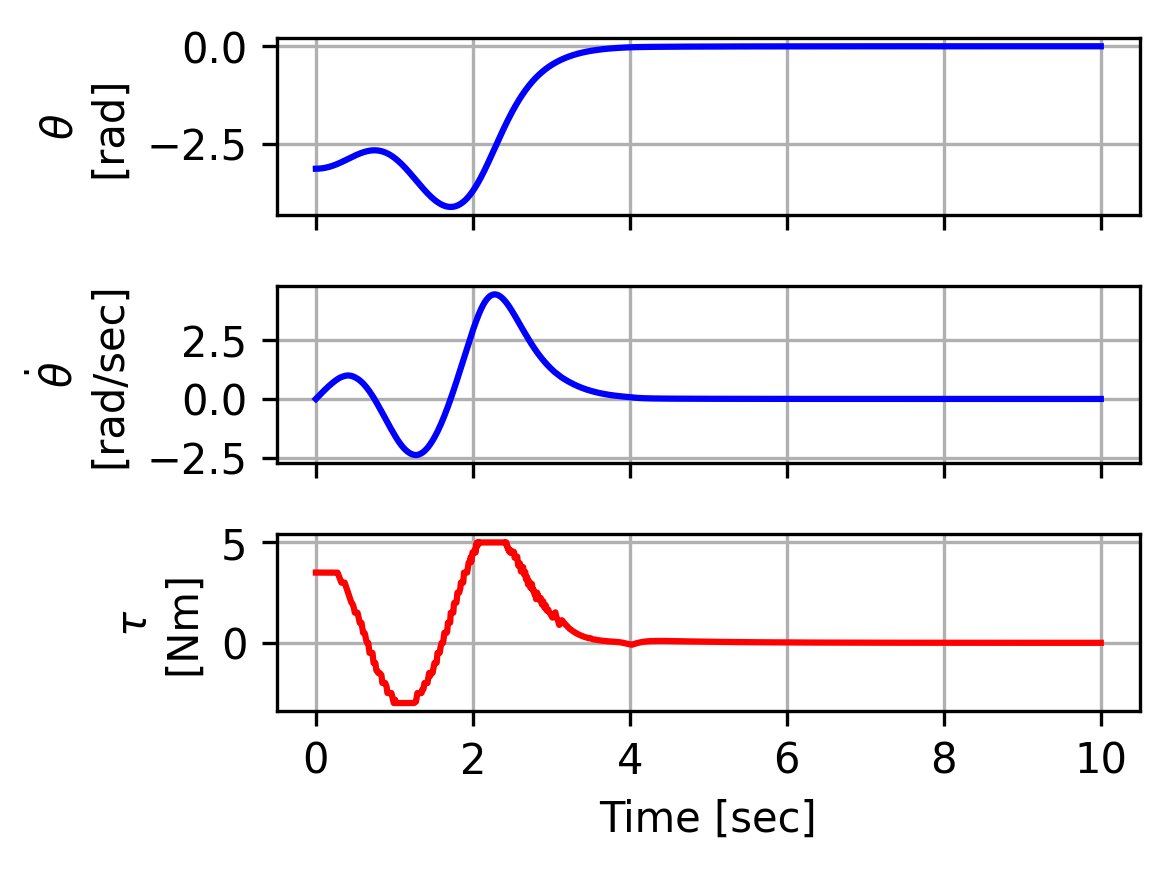

In [ ]:
dp , cl_sys  = case( m=1 , g=10 , l=1 , t_max_star=0.5 , q_star= 0.1 , case_name = 'c1', res = res, show = False)
# dp , cl_sys  = case( m=1 , g=10 , l=2 , t_max_star=0.5 , q_star= 0.1 , case_name = 'c2', res = res, show = False)
# dp , cl_sys  = case( m=2 , g=10 , l=1 , t_max_star=0.5 , q_star= 0.1 , case_name = 'c3', res = res, show = False)
# dp , cl_sys  = case( m=1 , g=10 , l=1 , t_max_star=1.0 , q_star= 0.05 , case_name = 'c4', res = res, show = False)
# dp , cl_sys  = case( m=1 , g=10 , l=2 , t_max_star=1.0 , q_star= 0.05 , case_name = 'c5', res = res, show = False)
# dp , cl_sys  = case( m=2 , g=10 , l=1 , t_max_star=1.0 , q_star= 0.05 , case_name = 'c6', res = res, show = False)
# dp , cl_sys  = case( m=1 , g=10 , l=1 , t_max_star=1.0 , q_star= 10.0 , case_name = 'c7', res = res, show = False)
# dp , cl_sys  = case( m=1 , g=10 , l=2 , t_max_star=1.0 , q_star= 10.0 , case_name = 'c8', res = res, show = False)
# dp , cl_sys  = case( m=2 , g=10 , l=1 , t_max_star=1.0 , q_star= 10.0 , case_name = 'c9', res = res, show = False)



## Output

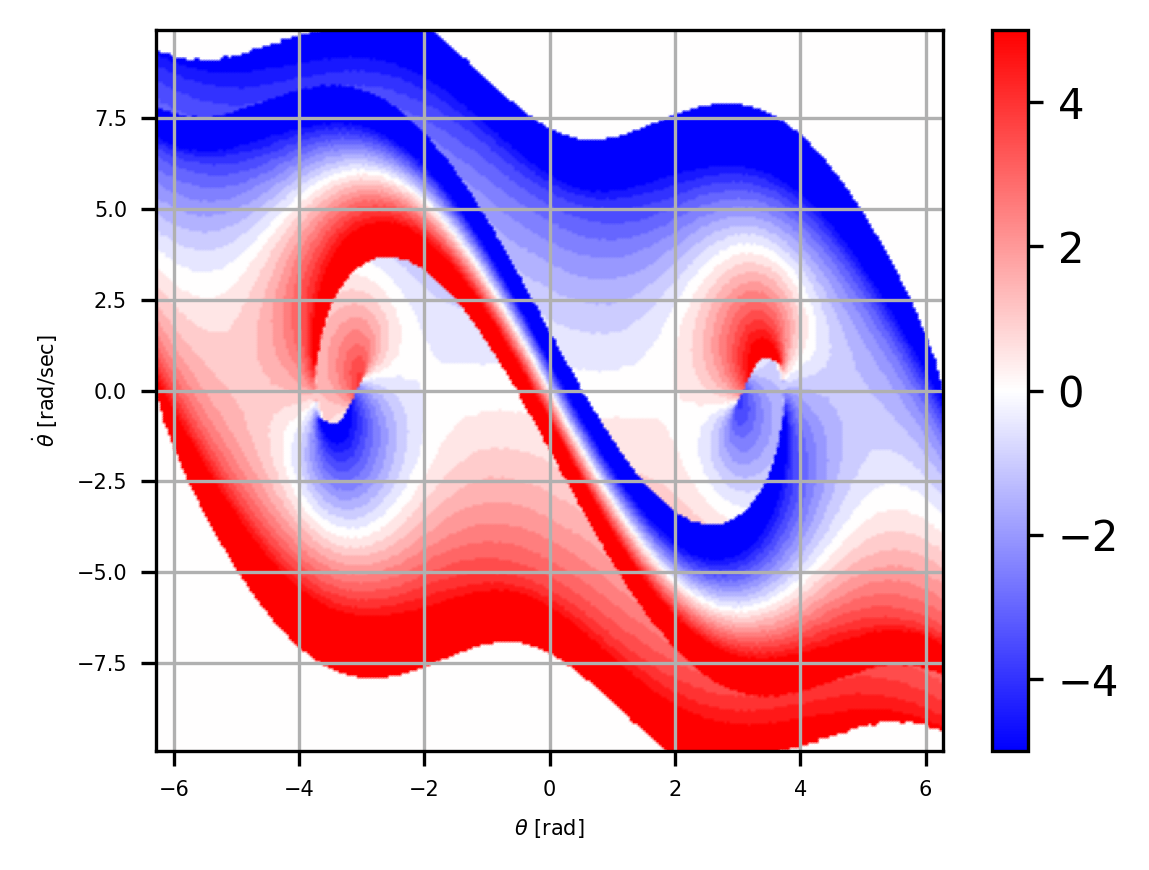

In [ ]:
dp.plot_policy()

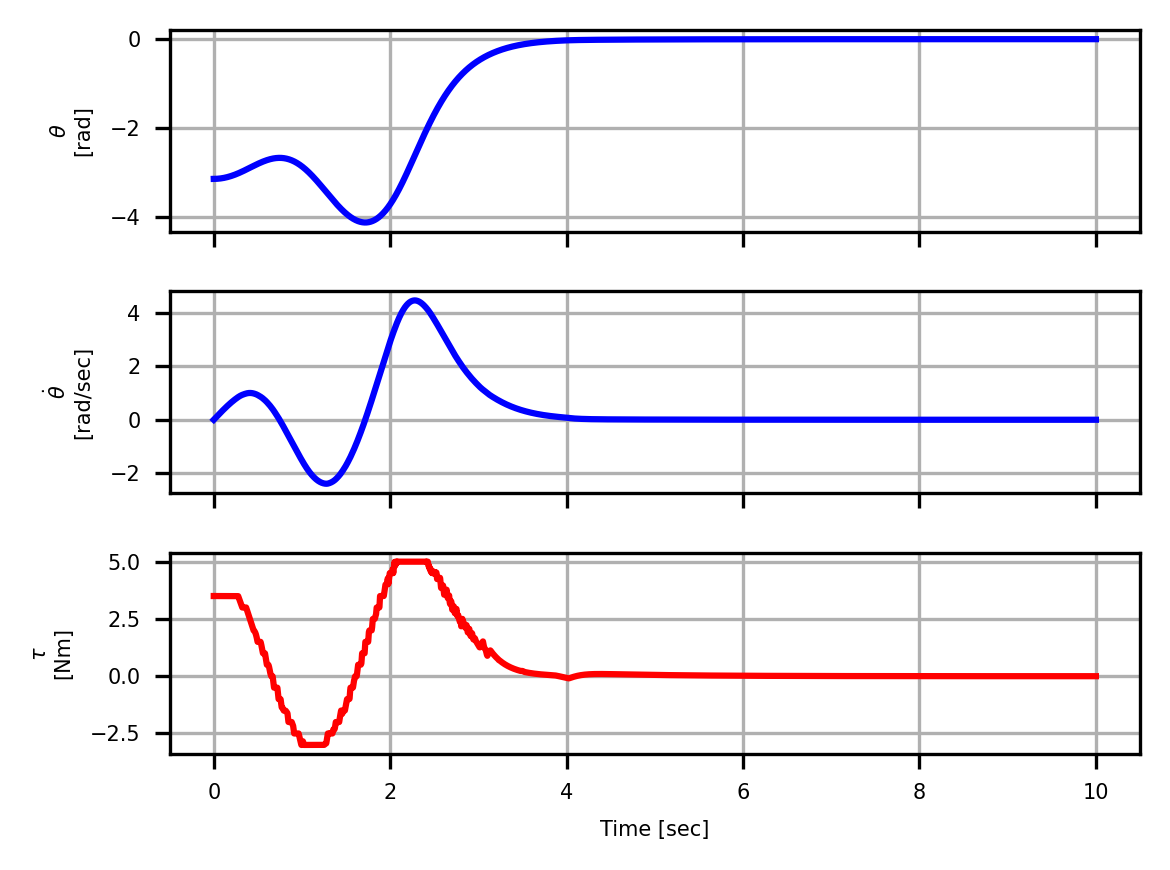

(<Figure size 1200x900 with 3 Axes>,
 array([<Axes: ylabel='$\\theta$\n[rad]'>,
        <Axes: ylabel='$\\dot{\\theta}$\n[rad/sec]'>,
        <Axes: xlabel='Time [sec]', ylabel='$\\tau$\n[Nm]'>], dtype=object))

In [ ]:
cl_sys.plot_trajectory('xu')

In [ ]:
ani  = cl_sys.generate_simulation_html_video()
html = display.HTML( ani )
display.display(html)

# Sensivity figures

## Source code

In [ ]:
def sensitivity( ts , qs , res = 'mid' , name = 'sensitivity' , legend = 1):

    rfig = plt.figure(figsize= (4, 3), dpi=300, frameon=True)
    rax  = rfig.add_subplot(1, 1, 1)

    rfig2 = plt.figure(figsize= (4, 3), dpi=300, frameon=True)
    rax2  = rfig2.add_subplot(1, 1, 1)

    n = ts.size


    for i in range(n):

        case( m=1 , g=10 , l=1 , t_max_star= ts[i] , q_star= qs[i] , case_name = name + '_level_' + str(i+1) , show = False, rax = rax, rax2 = rax2, res = res, legend = legend)


    rax.legend( loc = 'upper right' )
    rfig.tight_layout()
    rfig.show()
    rfig.savefig( name + '.pdf')
    rfig.savefig( name + '.png')
    rfig.savefig( name + '.jpg')

    rax2.legend( loc = 'upper right' )
    rfig2.tight_layout()
    rfig2.show()
    rfig2.savefig( name + '2.pdf')
    rfig2.savefig( name + '2.png')
    rfig2.savefig( name + '2.jpg')

    return (rfig, rax, rfig2, rax2)


## Computation

In [ ]:
# ts = np.array([  0.1,  0.3,  0.5,  1.0,  2.5,  5.0  ])
# qs = np.array([  0.05, 0.05, 0.05, 0.05, 0.05, 0.05 ])

# fig, ax, fig2, ax2 = sensitivity(ts, qs , res = res , name = 's_tmax', legend = 1)

In [ ]:
# ts = np.array([  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5 ])
# qs = np.array([  0.05, 0.10, 0.12, 0.15, 0.30, 0.50, 1.0,  2.0 ])

# fig, ax, fig2, ax2 = sensitivity(ts, qs , res = res , name = 's_q', legend = 2)